# VISUAL STEREO ODOMETRY

### Introduction

<div style="text-align:justify">
Stereo odometry is a technique for estimating the motion of a camera, or a mobile robot equipped with cameras, by analyzing the images captured by two or more cameras placed at different positions. It is a form of visual odometry that uses stereo vision to estimate the relative pose between successive frames of the camera. <br>
</div>

### Algorithm

<div style="text-align:justify">

In the following notebook, we will be using keypoint matches and depth maps to estimate odometry. Hence we will be using the 3D to 3D visual odometry algorithm shown below. <br>

<div style="text-align:center">
    <img src="Images/3d_to_3d_visual_odometry_algorithm.png" style="width: 75%; height: auto"/>
    <figcaption>3D to 3D Visual Odometry Algorithm</figcaption>
</div>

In this algorithm the 3D point coordinates of corresponding keypoints in two camera frames are assumed to be known (achieved through getting a depth map using Semi Global Matching algorithm ). We use this to determine the relative camera pose in the current time step with respect to the previous time step. 

We basically determine the rigid transformation that aligns two sets of 3D points by minimiizing the geometric least squares error. A closed form solution is available for this method. 

Link to Paper (Arun et al. 1987) : [Link](https://ieeexplore.ieee.org/document/4767965)
 
</div>

### Dataset

Link to KITTI Visual Odometry Dataset : [Link](https://www.cvlibs.net/datasets/kitti/eval_odometry.php)

For this project only the following datasets would be needed: 

1. odometry_data_set (grayscale , 22GB)
2. odometry_data_set (calibration_files , 1MB)
3. odometry_ground_truth_poses (4MB)
4. odometry_data_set (velodyne_laser_data .80 GB) --- OPTIONAL

**Note 1 :** We would be using the LIDAR data from the velodyne_laser_data set to compare the depths obtained from the stereo images vs lidar point clouds

**Note 2** Change the file paths based on your system to link the code to your dataset directory.  


### Sensor Setup
Link to details on the Sensor Setup : [Link](https://www.cvlibs.net/datasets/kitti/setup.php)


A reference picture of the sensor setup is shown below: 
<div style="text-align:center">
    <img src="Images/sensor_setup.png" style="width: 75%; height: auto"/>
</div>




In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

### Extract Ground Truth Trajectory for Sequence 1

In [2]:
gt_poses_raw = pd.read_csv('./dataset/data_odometry_poses/dataset/poses/00.txt' , delimiter=' ', header = None)
print("Shape of ground truth dataframe: " , gt_poses_raw.shape)
gt_poses_raw.head()

Shape of ground truth dataframe:  (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


The ground truth data (sequence 1) has 4541 rows corresponding to the number of image frames and 12 columns corresponding to the flattened 3x4 transformation matrix of the left stereo camera with respect to the global coordinate frame. 

The 3x4 transformation matrix contains a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector (R|t)

We can see this below

In [3]:
print('Starting position:')
start_pose = np.array(gt_poses_raw.iloc[0]).reshape((3,4)).round(2)
start_pose

Starting position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

As this is the start position, the rotation matrix is an identity matrix and the translation vector is a zero vector. 

Similarly the [R|t] transformation matrix can be used to represent the transformation between the current camera coordinate and the world coordinate frame. the world coordinate frame has been taken as the initial position of the camera. 

We now store the ground truth poses in a 3D numpy array 

In [4]:
gt_poses = np.zeros((len(gt_poses_raw),3,4))
for i in range(len(gt_poses_raw)):
    gt_poses[i] = np.array(gt_poses_raw.iloc[i]).reshape((3,4))

In [5]:
gt_poses[0]

array([[ 1.000000e+00,  9.043680e-12,  2.326809e-11,  5.551115e-17],
       [ 9.043683e-12,  1.000000e+00,  2.392370e-10,  3.330669e-16],
       [ 2.326810e-11,  2.392370e-10,  9.999999e-01, -4.440892e-16]])

During the course of this program , we dont need to be concerned with the rotation matrix as the camera rotation effects are implicit in the position of the camera origin over time.

We can extract the position of the camera (t) from the transformation matrix [R|t] in the following way

In [6]:
gt_poses[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

Here we see at the second time step , the value of z coordinate is positive , which means the car has moved forward. (The Z axis of the camera in the camera frame points outward)

In [7]:
%matplotlib inline

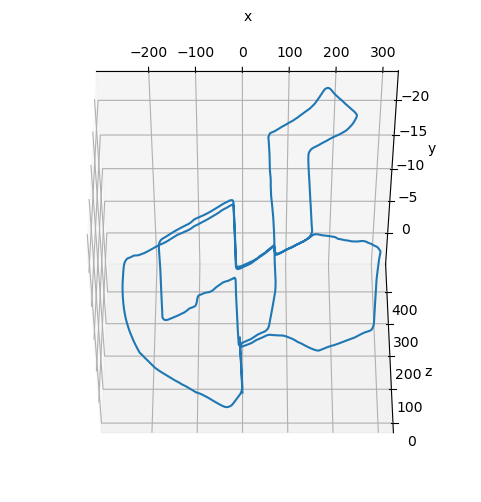

In [8]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt_poses[:, :, 3][:, 0], gt_poses[:, :, 3][:, 1], gt_poses[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

Here we see that the trajectory starts and ends at the same position. Also there seems to be a slight inclination along the y axis during the trajectory indicating the car may have traversed through a hill. 

Test image

In [9]:
test_image = cv2.imread("./dataset/data_odometry_gray/dataset/sequences/00/image_0/000000.png")

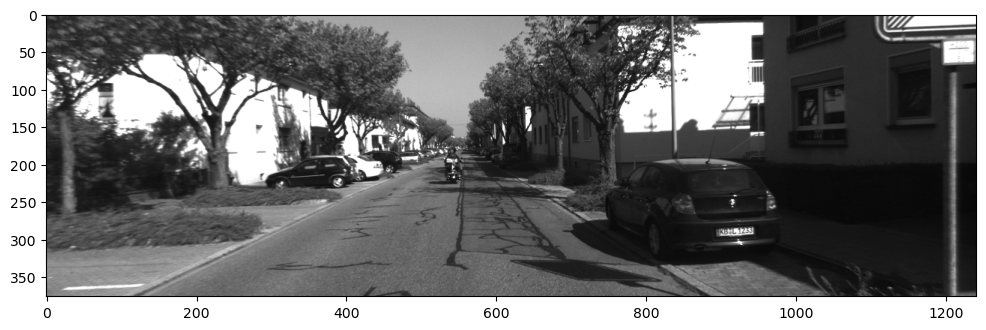

In [10]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_image)

Here we see the initial image from the grayscale camera (left). This is indicated as 000000.png in image 0 in sequence 0. 

Camera Calibration

In [11]:
calib_data = pd.read_csv("./dataset/data_odometry_calib/dataset/sequences/00/calib.txt", delimiter= ' ', header =  None , index_col=0)
calib_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


**Note**: If you do not see the 5th row in the dataframe labeled 'Tr' then the calibration file is incorrect. Please download the following calibration file from this link : [calibration_data](https://www.cvlibs.net/download.php?file=data_odometry_calib.zip) 

The txt file gives us the projection matrices of 4 cameras that have been mounted on the vehicle. P0 and P1 are the left and right grey scale cameras. P2 and P3 are the left and right color cameras. 

the projection matrix for each camera has been flattened out and can be reshaped and extracted. The Tr row is the transformation matrix data for the LIDAR. 

In [12]:
#Extracted Projection matrix for left grey camera
P0 = np.array(calib_data.loc['P0:']).reshape(3,4)
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

**NOTE:** The projection matrix for a camera from the calibration file is **after rectification** with respect to the stereo camera setup.

Usually the projection matrix of a camera takes a 3D point in the global coordinate frame and projects it into the pixel coordinates of that camera,s image frame.

Rectified projection matrix transforms 3D points from a world coordinate system to a rectified image coordinate system. They map points from each camera's coordinate frame onto the coordinate frame of a single image plane. In this case that would be the left camera. 

The rectified projection matrix is used in stereo vision applications to rectify the stereo image pair such that the corresponding epipolar lines are aligned horizontally. This simplifies the task of computing disparities between the stereo images and improves the accuracy of the stereo matching algorithm.



In [13]:
#Decomposition of projection matrix of right greyscale camera

P1 = np.array(calib_data.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix cam 1:' )
print(k1 ,"\n" )
print('Rotation Matrix cam 1:')
print(r1,"\n")
print('Translation Vector cam 1:')
print(t1.round(4),"\n")

#Decomposition of projection matrix of the left greyscale camera

P0 = np.array(calib_data.loc['P0:']).reshape((3,4))
k0, r0, t0, _, _, _, _ = cv2.decomposeProjectionMatrix(P0)
t0 = t0 / t0[3]
print('Intrinsic Matrix cam 0:')
print(k0 ,"\n")
print('Rotation Matrix cam 0:')
print(r0 ,"\n")
print('Translation Vector cam 0:')
print(t0.round(4), "\n")

Intrinsic Matrix cam 1:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 1:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 1:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]] 

Intrinsic Matrix cam 0:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]] 

Rotation Matrix cam 0:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

Translation Vector cam 0:
[[0.]
 [0.]
 [0.]
 [1.]] 



In [14]:

# Get the rotation and translation vector of right camera in the form [R|t]
Rt_cam1 = np.hstack([r1,t1[:3]]).round(4)
print("Transformation Matrix Camera 1")
print(Rt_cam1,"\n")
#Extract translation vector 
print("Translation vector Camera 1")
origin = np.array([0,0,0,1])
Rt_cam1.dot(origin).round(4).reshape(-1,1)

Transformation Matrix Camera 1
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]] 

Translation vector Camera 1


array([[0.5372],
       [0.    ],
       [0.    ]])

The positive value (+0.54) in the translation vector of the right camera shows that the world coordinate is the left camera. 


### Dataset Handler

<div style="text-align:justify">

A dataset handler will make the data from our dataset more accesible. If all the images in the dataset are loaded at once into a list and then accessed, it would take up too much space in the RAM. Instead, using a generator with a buffer of 1 we can access the image file from the directory one after the other using the custom dataset handler. We need a buffer of 1 as we would want to compare the image pair at timestep t to the pair at t-1 .  

**Note:** If the LIDAR data is used, it is important to tell numpy to decode the velodyne binaries as float32 as by default it decodes to float64 and thus the decoded information would be incorrect. 

</div>

In [15]:
class Dataset_Handler():

    """A short description of what the class does.

    More detailed description of the class goes here.

    Attributes:
        attribute1 (type): Description of attribute1.
        attribute2 (type): Description of attribute2.

    Methods:
        method1(arguments): Description of method1.
        method2(arguments): Description of method2.
    """

    def __init__(self , sequence , lidar_data_option = False ):


        # If LIDAR data is being supplied to the odometry function , set lidar_data to True else set it to False
        
        self.lidar_data_option = lidar_data_option

        #Set paths to the image sequence directory, the ground truth directory , sensor calibration data directory
        self.img_seq_dir = './dataset/data_odometry_gray/dataset/sequences/{}/'.format(sequence) #File path to image sequence folder
        self.gt_poses_dir = './dataset/data_odometry_poses/dataset/poses/{}.txt'.format(sequence) #File path to ground truth poses
        self.calib_data_dir = './dataset/data_odometry_calib/dataset/sequences/{}'.format(sequence) #File path to camera calibration data
        

        #Files to iterate through 
        self.left_camera_image_files = os.listdir(self.img_seq_dir +'image_0')
        self.right_camera_image_files = os.listdir(self.img_seq_dir +'image_1')

        #################################### check ####################################
        if self.lidar_data_option :
            self.velodyne_files = os.listdir(self.seq_dir + 'velodyne')
            self.lidar_path = self.seq_dir + 'velodyne/'
        ###############################################################################


        # Extract Sensor Calibration Parameters
        # P0,P1 - greyscale cameras , P2,P3 - RGB Cameras , Tr - Transformation matrix of Velodyne LIDAR
        sensor_calib_data = pd.read_csv(self.calib_data_dir + '/calib.txt', delimiter=' ', header = None , index_col=0)
        
        self.P0 = np.array(sensor_calib_data.loc['P0:']).reshape((3,4))
        self.P1 = np.array(sensor_calib_data.loc['P1:']).reshape((3,4))
        self.P2 = np.array(sensor_calib_data.loc['P2:']).reshape((3,4))
        self.P3 = np.array(sensor_calib_data.loc['P3:']).reshape((3,4))  
        self.Tr = np.array(sensor_calib_data.loc['Tr:']).reshape((3,4))

        #Extract ground truth poses
        gt_poses = pd.read_csv(self.gt_poses_dir , delimiter=' ' , header = None)
        self.gt = np.zeros((len(gt_poses) , 3,4))

        for i in range(len(gt_poses)): 
            self.gt[i] = np.array(gt_poses.iloc[i]).reshape((3,4))

        #Extract image timestamps
        self.time_stamps = np.array(pd.read_csv(self.calib_data_dir + '/times.txt' , delimiter = ' ' , header = None ))

        #Load Image and LIDAR Data

        self.reset_generator()

        self.first_image_left = cv2.imread(self.img_seq_dir + 'image_0/' + self.left_camera_image_files[0],0)
        self.first_image_right= cv2.imread(self.img_seq_dir + 'image_1/' + self.right_camera_image_files[0],0)
        self.second_image_left= cv2.imread(self.img_seq_dir + 'image_1/' + self.left_camera_image_files[1],0)

        #################### Load LIDAR Data #################################

        ######################################################################

        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
        
    def reset_generator(self):

        self.images_left = (cv2.imread(self.img_seq_dir + 'image_0/' + name_left , 0)
                            for name_left in self.left_camera_image_files)
        self.images_left = (cv2.imread(self.img_seq_dir + 'image_1/' + name_right , 0)
                            for name_right in self.left_camera_image_files)
        
        ########################## Reset LIDAR generator #########################

        pass

In [16]:
sensor_data = Dataset_Handler('00')

### Disparity Map

<div style="text-align:justify">

In order to generate the depth map using a stereo camera , we need three parameters: 
* Focal length of the cameras (f)
* Baseline between cameras (b)
* Disparity in poxel value(d)

$$d = x_{l} - x_{r}$$

here $x_{l}$ and $x_{r}$ are the differences in horizontal pixel location of the point projected onto the left and right image planes

The equation to get the depth of a pixel in the picture is as follows: 

$$Z = \frac{fb}{d}$$


the focal length and the baseline are parameters of the camers. We can get the disparity map of the image using stereo matching. Algorithms such as StereoBM and StereoSGBM are widely used for this purpose. StereoSGBM gives better results thaan StereoBM.The main reason for this is that StereoSGBM uses a more advanced matching algorithm than StereoBM. StereoBM uses a simple block matching algorithm, which works by comparing pixels in a local window between the left and right images. However, this approach can fail in regions with textureless or repetitive patterns, resulting in incorrect depth estimates.

StereoSGBM, on the other hand, uses a more sophisticated semi-global matching algorithm that takes into account not only local pixel similarities but also the smoothness of the disparity map. It uses multiple paths to find the best match and combines the results to obtain a more robust disparity map. As a result, StereoSGBM is more effective in handling challenging scenes with textureless or repetitive patterns, producing more accurate depth maps than StereoBM. However, this comes at the cost of higher computational complexity and longer processing time.

</div>


    

In [18]:
def compute_left_disparity_map(left_image , right_image , match_algo = 'bm' , rgb = False , verbose = False):

    '''
    This function takes the image pair from the left and right cameras and computes the disparity map for the left image. 

    Argument Description: 

    left_image -- image obtained from the left camera
    right_image -- image obtained from the right camera

    Optional Arguments: 

    match_algo -- (str) -- 'bm' to use StereoBM or 'sgbm' to use StereoSGBM matching
    rgb -- (bool) -- True if the inputs are RGB
    verbose --(bool) -- True to report matching type and computation time

    Returns:
    disparity_left -- disparity map for the left camera image

    
    '''

    window = 6
    num_disp =  window*16
    block_size = 11

    if match_algo == 'bm':

        matcher = cv2.StereoBM_create(numDisparities=num_disp , blockSize= block_size)

    elif match_algo == 'sgbm':
        
        matcher = cv2.StereoSGBM_create(numDisparities=num_disp, 
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8*3*window**2,
                                        P2 = 32*3*window**2,
                                        mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                        )
        
    if rgb:
        left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    start = datetime.datetime.now()
    disparity_left = matcher.compute(left_image, right_image).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{match_algo.upper()}:', end-start)
    
    return disparity_left
        


In [19]:
%matplotlib inline

Time to compute disparity map using StereoBM: 0:00:00.021452


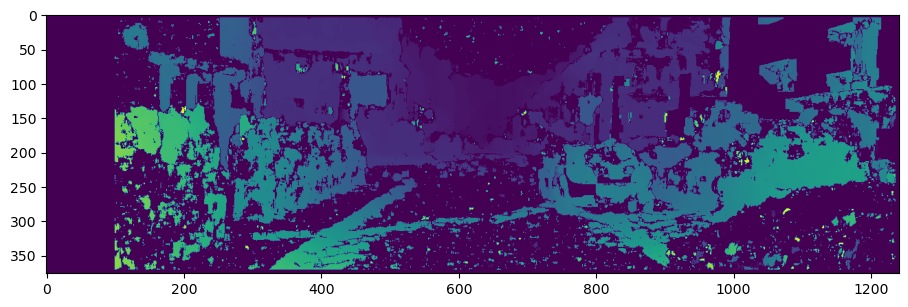

In [22]:
## Disparity map using StereoBM

disp = compute_left_disparity_map(sensor_data.first_image_left, 
                                  sensor_data.first_image_right, 
                                  match_algo='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Time to compute disparity map using StereoSGBM: 0:00:00.075461


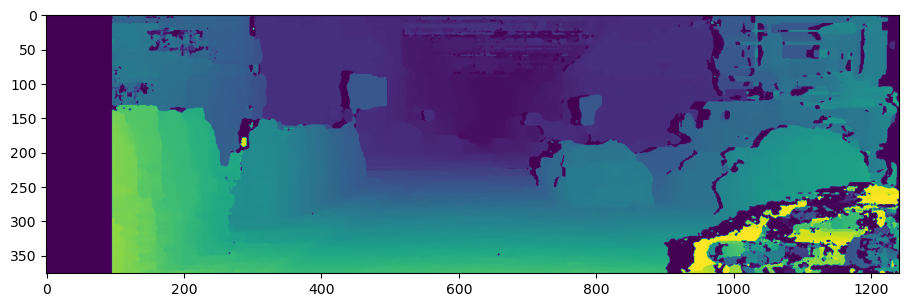

In [24]:
# Disparity map using StereoSGBM

disp = compute_left_disparity_map(sensor_data.first_image_left, 
                                  sensor_data.first_image_right, 
                                  match_algo='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)


<div style="text-align:justify">
We see that the Stereo SGBM algorithm takes around 3x longer but produces a much better disparity map with less information gaps. 

We also see that there is a gap on the left side of the image where the right camera did not have matching information. This means we can apply a mask when looking for features to match from one frame to the next so that we can use features which will fall in the area of the picture for which we have depth information. 
</div>

In [25]:
disp[0,0]

-1.0

We see that the function places a -1.0 value wherever it gets improper or missing data